# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [ ]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [ ]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

In [ ]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv("P52_all_cell_RGB_features.csv", header=False)

In [4]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv("P52_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 121856 × 672

In [5]:
adata.obs

Empty DataFrame
Columns: []
Index: [P52_FOV01_cell_1, P52_FOV01_cell_2, P52_FOV01_cell_3, P52_FOV01_cell_4, P52_FOV01_cell_5, P52_FOV01_cell_6, P52_FOV01_cell_7, P52_FOV01_cell_8, P52_FOV01_cell_9, P52_FOV01_cell_10, P52_FOV01_cell_11, P52_FOV01_cell_12, P52_FOV01_cell_13, P52_FOV01_cell_14, P52_FOV01_cell_15, P52_FOV01_cell_16, P52_FOV01_cell_17, P52_FOV01_cell_18, P52_FOV01_cell_19, P52_FOV01_cell_20, P52_FOV01_cell_21, P52_FOV01_cell_22, P52_FOV01_cell_23, P52_FOV01_cell_24, P52_FOV01_cell_25, P52_FOV01_cell_26, P52_FOV01_cell_27, P52_FOV01_cell_28, P52_FOV01_cell_29, P52_FOV01_cell_30, P52_FOV01_cell_31, P52_FOV01_cell_32, P52_FOV01_cell_33, P52_FOV01_cell_34, P52_FOV01_cell_35, P52_FOV01_cell_36, P52_FOV01_cell_37, P52_FOV01_cell_38, P52_FOV01_cell_39, P52_FOV01_cell_40, P52_FOV01_cell_41, P52_FOV01_cell_42, P52_FOV01_cell_43, P52_FOV01_cell_44, P52_FOV01_cell_45, P52_FOV01_cell_46, P52_FOV01_cell_47, P52_FOV01_cell_48, P52_FOV01_cell_49, P52_FOV01_cell_50, P52_FOV01_cell_51, P52_FOV01_cell_52, P52_FOV01_cell_53, P52_FOV01_cell_54, P52_FOV01_cell_55, P52_FOV01_cell_56, P52_FOV01_cell_57, P52_FOV01_cell_58, P52_FOV01_cell_59, P52_FOV01_cell_60, P52_FOV01_cell_61, P52_FOV01_cell_62, P52_FOV01_cell_63, P52_FOV01_cell_64, P52_FOV01_cell_65, P52_FOV01_cell_66, P52_FOV01_cell_67, P52_FOV01_cell_68, P52_FOV01_cell_69, P52_FOV01_cell_70, P52_FOV01_cell_71, P52_FOV01_cell_72, P52_FOV01_cell_73, P52_FOV01_cell_74, P52_FOV01_cell_75, P52_FOV01_cell_76, P52_FOV01_cell_77, P52_FOV01_cell_78, P52_FOV01_cell_79, P52_FOV01_cell_80, P52_FOV01_cell_81, P52_FOV01_cell_82, P52_FOV01_cell_83, P52_FOV01_cell_84, P52_FOV01_cell_85, P52_FOV01_cell_86, P52_FOV01_cell_87, P52_FOV01_cell_88, P52_FOV01_cell_89, P52_FOV01_cell_90, P52_FOV01_cell_91, P52_FOV01_cell_92, P52_FOV01_cell_93, P52_FOV01_cell_94, P52_FOV01_cell_95, P52_FOV01_cell_96, P52_FOV01_cell_97, P52_FOV01_cell_98, P52_FOV01_cell_99, P52_FOV01_cell_100, ...]

[121856 rows x 0 columns]

In [6]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

Timepoint Clinical outcome
P51_FOV01         A               PD
P51_FOV02         A               PD
P51_FOV03         A               PD
P51_FOV04         A               PD
P51_FOV05         A               PD
...             ...              ...
P58_FOV19         C               SD
P58_FOV20         C               SD
P58_FOV21         C               SD
P58_FOV22         C               SD
P58_FOV23         C               SD

[141 rows x 2 columns]

In [7]:
# get FOV and cell number from cell ID o

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_1272553/4186933571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_1272553/4186933571.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


FOV cell_ID Timepoint
P52_FOV01_cell_1     01       1         A
P52_FOV01_cell_2     01       2         A
P52_FOV01_cell_3     01       3         A
P52_FOV01_cell_4     01       4         A
P52_FOV01_cell_5     01       5         A
...                  ..     ...       ...
P52_FOV25_cell_8524  25    8524         C
P52_FOV25_cell_8525  25    8525         C
P52_FOV25_cell_8526  25    8526         C
P52_FOV25_cell_8527  25    8527         C
P52_FOV25_cell_8528  25    8528         C

[121856 rows x 3 columns]

In [8]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs (excluding FOV07)

In [12]:
tp = 'A'

In [13]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 41915 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

In [14]:
# FOV07 RBCs have noticably different appearence from the rest and were therefore clustered separately
adata = adata[adata.obs['FOV'] != '07']

## Pre-Processing

### Log-Transformation

In [15]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [16]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

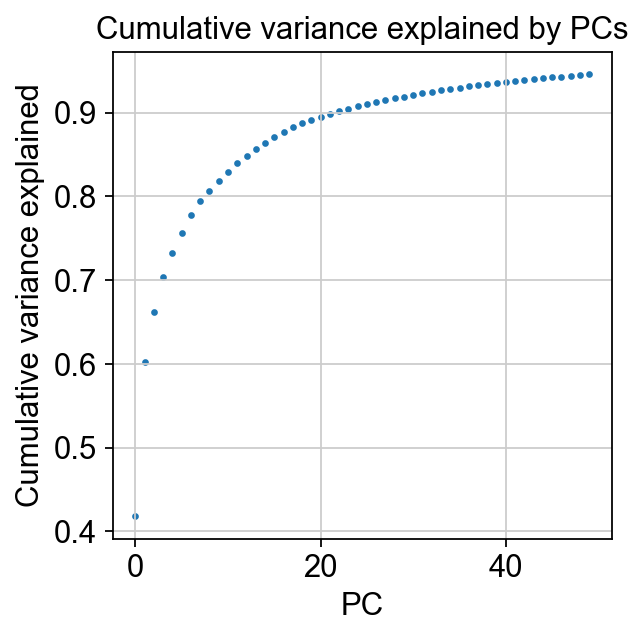

In [17]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [18]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [19]:
k = 50 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 25.27243185043335 seconds
Jaccard graph constructed in 20.373203992843628 seconds
Wrote graph to binary file in 0.5848774909973145 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.711674
After 18 runs, maximum modularity is Q = 0.712705
After 36 runs, maximum modularity is Q = 0.71529
Louvain completed 56 runs in 62.73776173591614 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 110.78020167350769 seconds


In [20]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


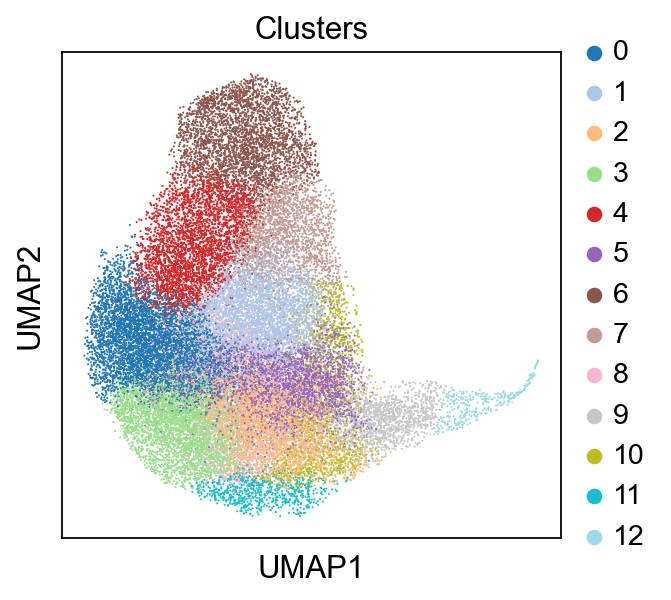

In [21]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


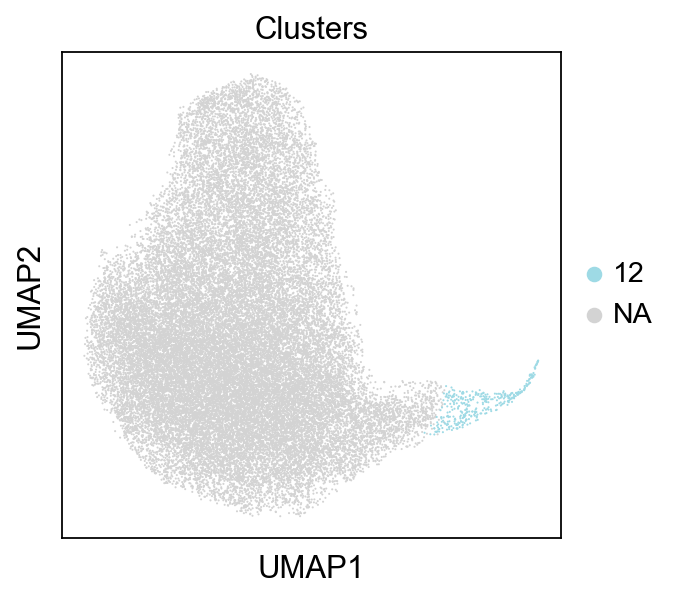

In [22]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[12]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


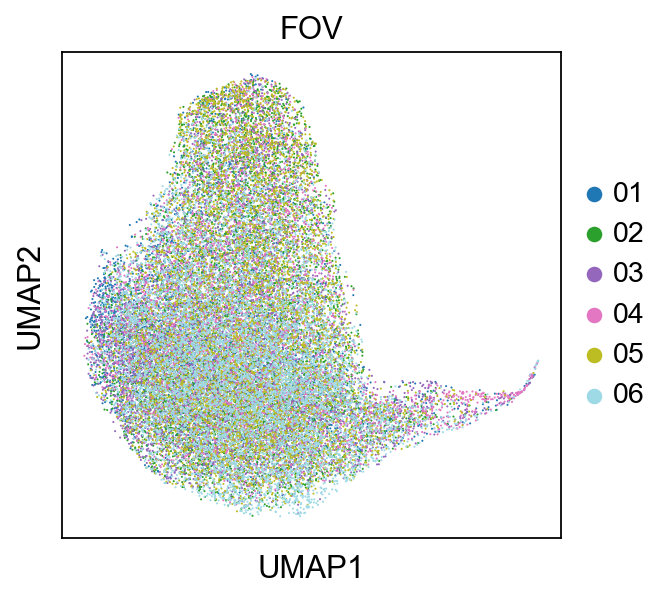

In [23]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [25]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/P52' + tp + '_RGB_clusters_exFOV07.csv')

In [26]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/P52' + tp + '_RGB_cell_features_clustered_exFOV07.h5ad')

## Cluster Timepoint A FOVs for RBCs (only FOV07)

In [27]:
tp = 'A'

In [28]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 41915 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

In [29]:
# FOV07 RBCs have noticably different appearence from the rest and were therefore clustered separately
adata = adata[adata.obs['FOV'] == '07']

## Pre-Processing

### Log-Transformation

In [30]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [31]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

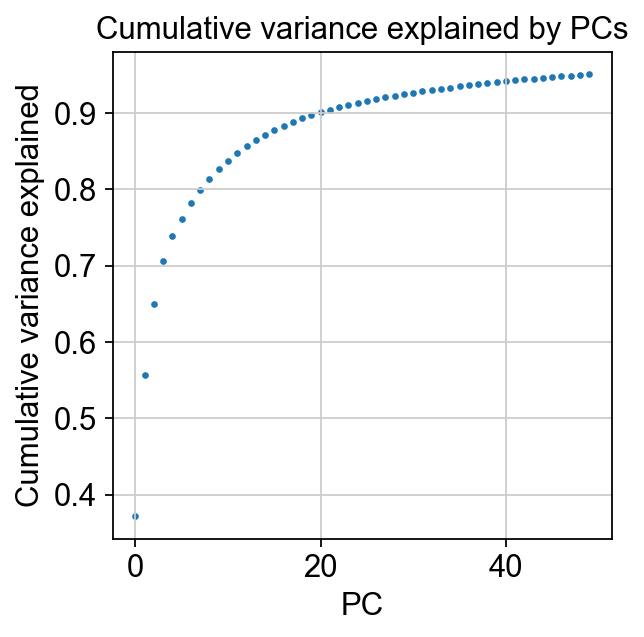

In [32]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [33]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [34]:
k = 50 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1821084022521973 seconds
Jaccard graph constructed in 5.470783710479736 seconds
Wrote graph to binary file in 0.12466144561767578 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.712788
After 2 runs, maximum modularity is Q = 0.716466
Louvain completed 22 runs in 3.4693334102630615 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 12.4064040184021 seconds


In [35]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


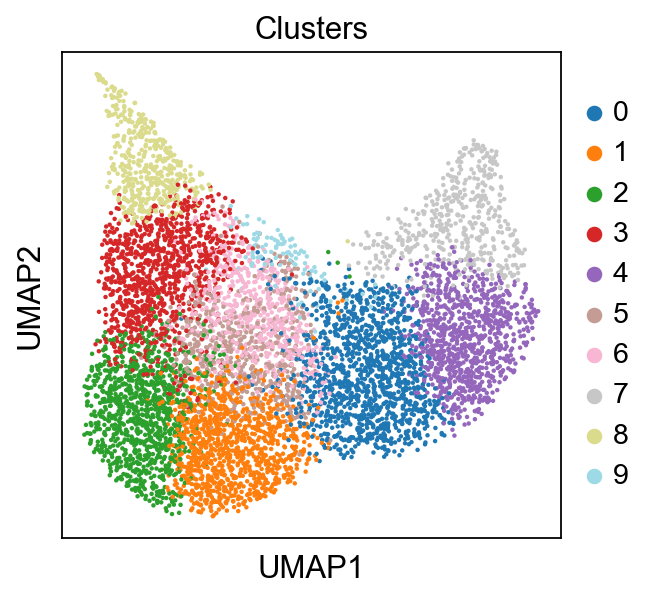

In [36]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


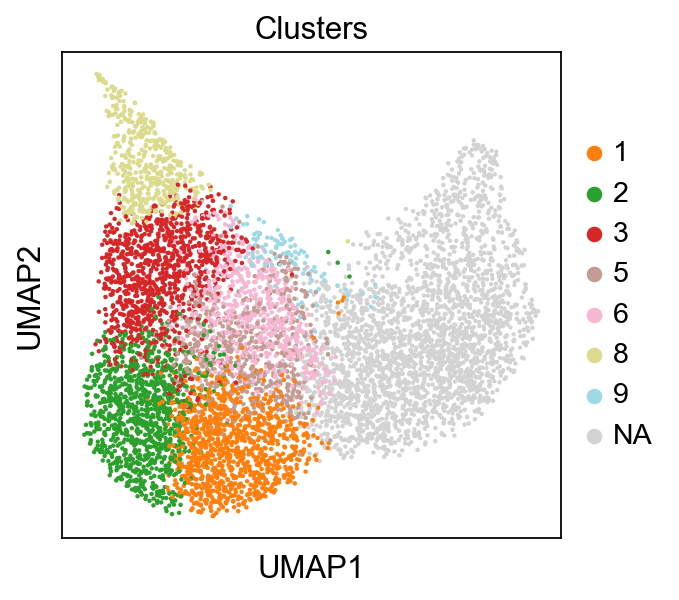

In [42]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[1,2,3,5,6,8,9]
)

In [39]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/P52' + tp + '_RGB_clusters_FOV07.csv')

In [40]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/P52' + tp + '_RGB_cell_features_clustered_FOV07.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [43]:
tp = 'B'

In [44]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 32300 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [45]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [46]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

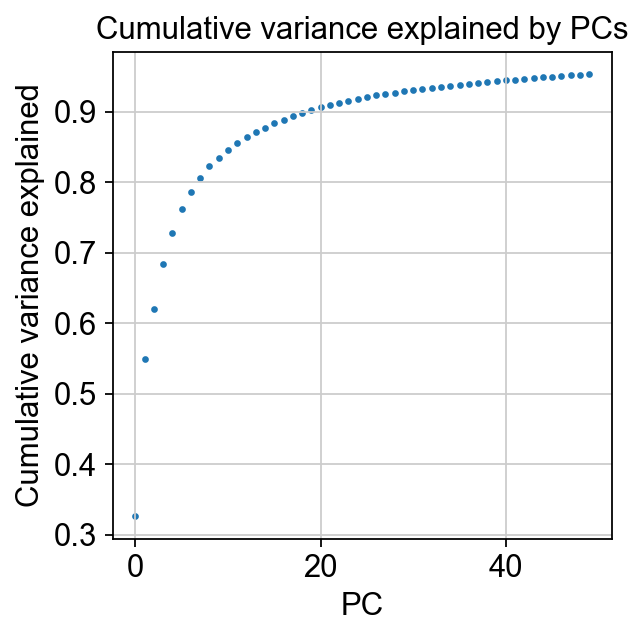

In [47]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [48]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [49]:
k = 50 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 21.707212209701538 seconds
Jaccard graph constructed in 18.957327604293823 seconds
Wrote graph to binary file in 0.5638785362243652 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.74441
Louvain completed 21 runs in 25.912373781204224 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 69.65974187850952 seconds


In [50]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [51]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


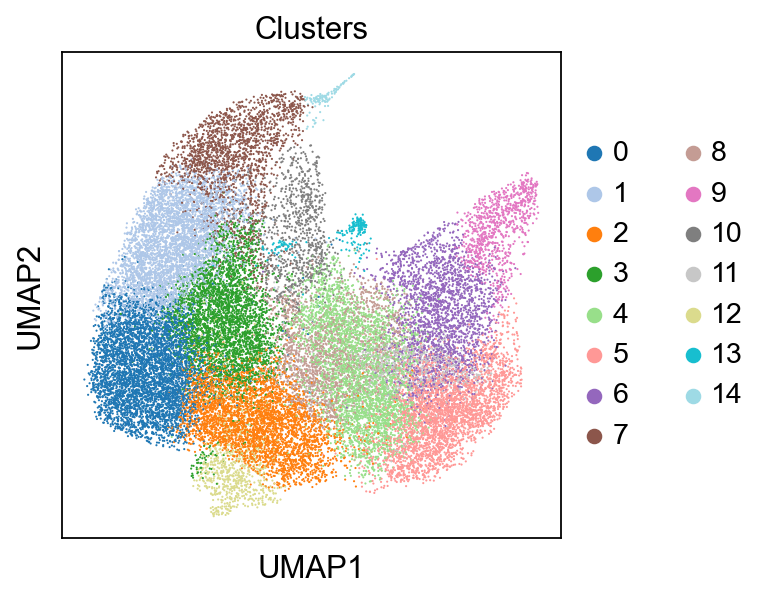

In [52]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


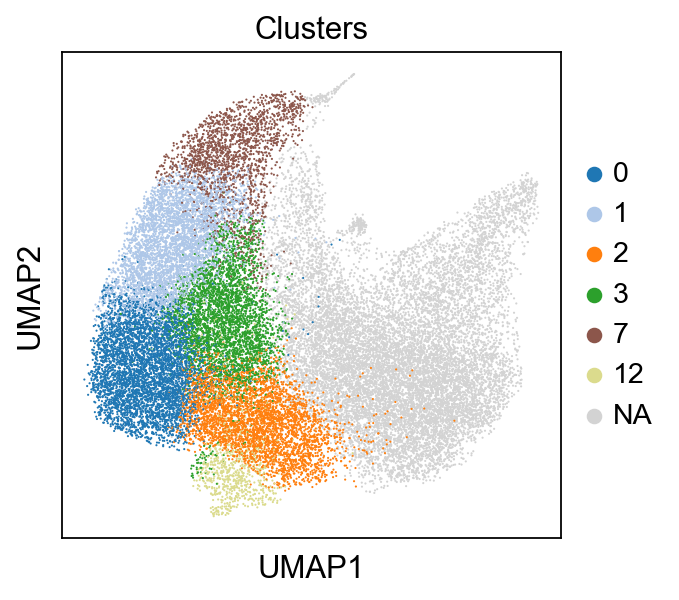

In [60]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,2,3,7,12]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


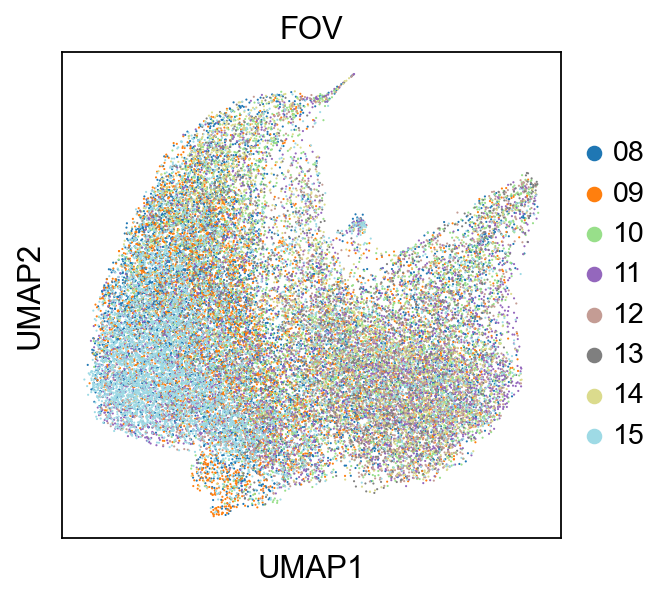

In [53]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [54]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/P52' + tp + '_RGB_clusters.csv')

In [55]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/P52' + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [84]:
tp = 'C'

In [85]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 47641 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [86]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [87]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

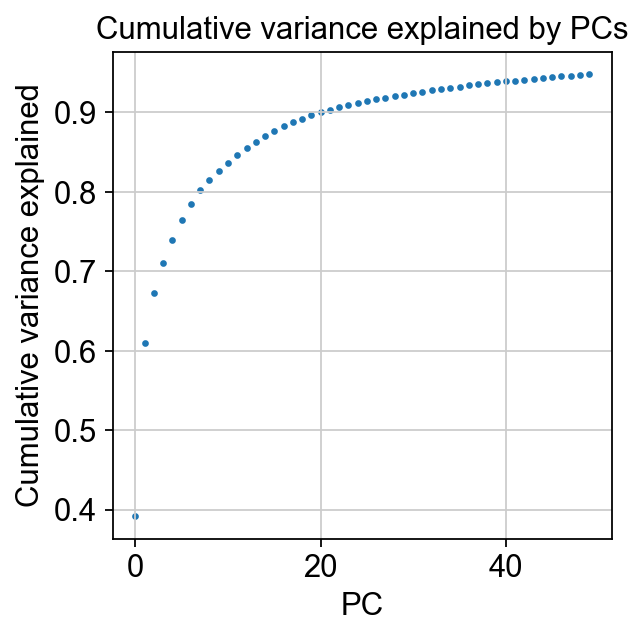

In [88]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [89]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [90]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 47.573593616485596 seconds
Jaccard graph constructed in 7.399357795715332 seconds
Wrote graph to binary file in 0.2229912281036377 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.772285
After 2 runs, maximum modularity is Q = 0.773676
After 3 runs, maximum modularity is Q = 0.776217
After 16 runs, maximum modularity is Q = 0.777437
Louvain completed 36 runs in 19.780038833618164 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 77.32710218429565 seconds


In [91]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [92]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


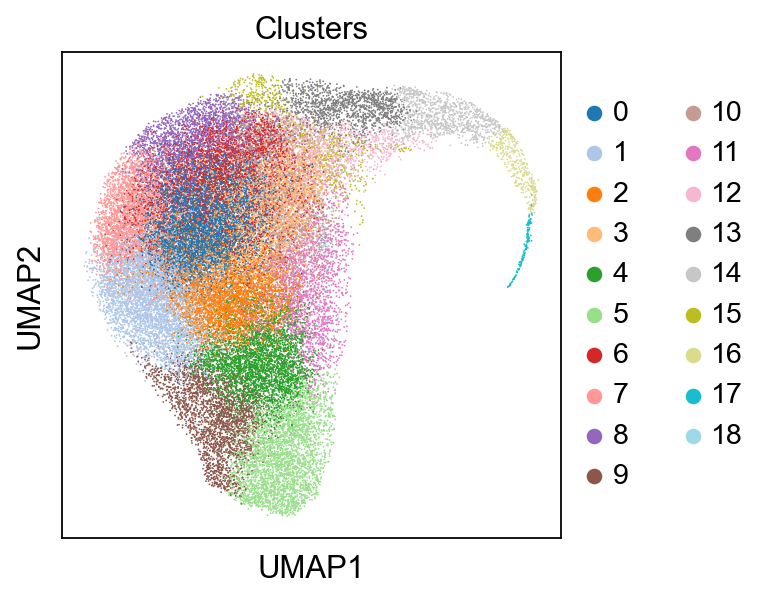

In [93]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


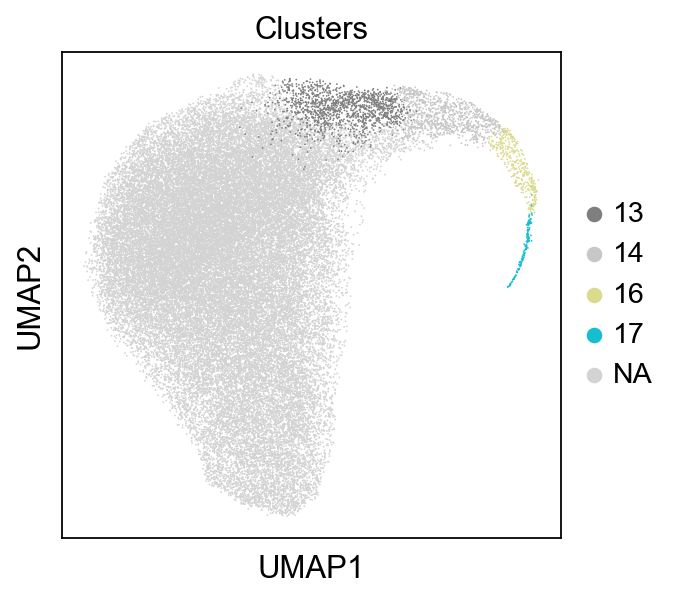

In [95]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[13,14,16,17]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


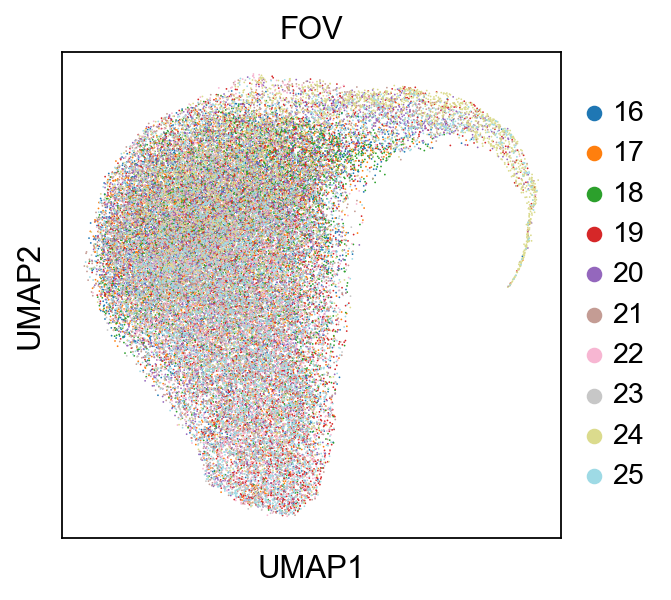

In [96]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [97]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/P52' + tp + '_RGB_clusters.csv')

In [98]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/P52' + tp + '_RGB_cell_features_clustered.h5ad')